In [1]:
import numpy as np
from lusidtools.jupyter_tools import toggle_code

"""Interest Rate Swap Valuation

Demonstrates pricing of an Interes Rate Swap based on a user defined Instrument.

Attributes
----------
instruments
aggregation
market data store
results store
quotes
"""

toggle_code("Hide docstring")

In [2]:
# Import LUSID
import lusid as lu
import lusid.models as lm

from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import Libraries
from datetime import datetime, timedelta, time
from IPython.display import display_html
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from lusidjam.refreshing_token import RefreshingToken
import json
import os

# Settings and utility functions to display objects and responses more clearly.
pd.set_option('float_format', '{:,.4f}'.format)

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

if secrets_path is None:
  secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

api_factory = lu.utilities.ApiClientFactory(
        token=RefreshingToken(),
        api_secrets_filename = secrets_path,
        app_name="LusidJupyterNotebook")

print ('LUSID Environment Initialised')
print ('LUSID SDK Version: ', api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version)


LUSID Environment Initialised
LUSID SDK Version:  0.6.9569.0


## Interest Rate Swap Valuation 

This notebook illustrates construction of an interest rate swap and using the LUSID instrument definition. With the instrument setup, the notebook will cover valuations and cash flow projections as well as some handling for life cycle events.

For valuations, we will be looking to use the LUSID valuation engine's _'Discounting'_ model, which will depend on a set of user-defined curves to discount each cash flows and project resets.

The example instrument we will be constructing is a vanilla interest rate swap with the following parameters:

    -  Coupon Rate: 2%
    -  Spread: 0bp
    -  Start Date: 01/10/2019
    -  Maturity: ~10Y (front stub)
    -  Currency: USD
    -  Payment Frequency: 6M
    -  Index: ESTRON 1D
    -  Side: Receive Fixed

Notice the selection of an OIS/RFR based rate for the floating leg, which the system currently supports for calculation of accruals under various methods that include look-back averages and compounding on the overnight rate.

### Table of contents
1. [Setup LUSID and relevant objects](#1.-Setup-LUSID-and-required-API-objects)
  * [1.1 Interest Rate Swap Definition](#1.1-Interest-Rate-Swap-Definition)
  * [1.2 Curves and Market Data](#1.2-Curve-and-Market-Data)
  * [1.3 Setup Portfolio](#1.3-Setup-Portfolio)
  * [1.4 Add Transactions](#1.4-Add-Transactions)
2. [Valuation and Cash Flows](#2.-Valuation)
  * [2.1 Configure the valuation recipe](#2.1-Configure-the-valuation-recipe)
  * [2.2 Cash Flows](#2.2-Cash-Flows)
  * [2.3 Curves](#2.3-Curves)
  * [2.4 Valuation](#2.4-Valuation)
  * [2.5 Cash Flow Overrieds](#2.5-Cash-Flow-Overrides)
3. [Instrument Life Cycle](#3.-Instrument-Life-Cycle-and-Overrides)
  * [3.1 Cash Handling on Payment Date](#3.1-Cash-Handling-on-Payment-Date)
4. [P&L Reporting](#4.-P&L-Reporting)
  * [4.1 A2B Report for P&L](#4.1-A2B-Report-for_P&L)

## 1. Setup LUSID and relevant objects

In [3]:
# Initiate the LUSID APIs required for the notebook
instruments_api = api_factory.build(lu.api.InstrumentsApi)
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
quotes_api = api_factory.build(lu.api.QuotesApi)
complex_market_data_api = api_factory.build(lu.api.ComplexMarketDataApi)
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
aggregation_api = api_factory.build(lu.AggregationApi)
structured_result_data_api = api_factory.build(lu.api.StructuredResultDataApi)

In [4]:
# Define helper tools
def df_add_utc(df: pd.DataFrame) -> None:
    # UTC methods for common naive datetime types
    date_conv_methods = {
        'datetime': lambda x: x.replace(tzinfo=pytz.utc),
        'datetime64[ns]': lambda x: x.tz_localize('UTC')
    }

    for column in df.columns:
        dtyp = str(df[column].dtype)
        # Add tzinfo to naive series or dt object
        if dtyp in date_conv_methods.keys():
            df[column] = df[column].map(date_conv_methods.get(dtyp))

def get_instrument(
        identifier: str,
        identifier_type: str="ClientInternal",
        scope: str=None,
   )-> lm.Instrument:
    return instruments_api.get_instrument(
        identifier_type=identifier_type,
        identifier=identifier,
        scope=scope
    )


### 1.1 Interest Rate Swap Definition

We can begin by setting the contract details of the swap which we will feed into LUSID. In this case we will be looking at a 10y EUR-OIS swap with a short front stub.

In [5]:
# Set swap details
trade_date = datetime(2022, 2, 10, 0, 0, tzinfo=pytz.utc)
start_date = trade_date
end_date = datetime(2032, 1, 31, 0, 0, tzinfo=pytz.utc)
instrument_ccy = "EUR"
payment_frequency = "6M"
index_tenor = "1D"
reference_index = "ESTRON"
notional = 10000000
cpn = 0.02
spread = 0
day_count_convention = "Actual360"
stub_type = "ShortFront"
name = "EUROIS.REC.10Y"
instrument_identifier = "EUR-OIS-SWAP001"

# Set the valuation date
effective_at = datetime(2022, 6, 10, 0, 0, tzinfo=pytz.utc)

Within LUSID, an interest rate swap will need to be defined by first creating each leg, which will depend on a [_flow convention_](https://www.lusid.com/docs/api#operation/UpsertFlowConventions) that sets the payment details. As shown below, this  is where we determine details such as the payment frequency and day count conventions.

Notice that in this example we unitize the swap notional and pass a value of 1, where the actual notional will be passed on the transaction/holding level.

For the floating leg, we will also use a model that sets the [_index convention_](https://www.lusid.com/docs/api#operation/UpsertIndexConvention), which is where we will specify details relating to the ESTRON reference index. The details in the index convention will later be used to tie the instrument back to market data elements such as ESTRON fixings and the related forward curve.

In [6]:
# Set the scope of the instruments (optional/nullable)
instrument_scope = "EurOisNotebook"

In [7]:
# Create the fixed leg details
fixed_flows = lm.FlowConventions(
    currency=instrument_ccy,
    payment_frequency=payment_frequency,
    day_count_convention=day_count_convention,
    roll_convention="ModifiedFollowing",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=0,
    reset_days=0
)

fixed_leg_definition = lm.LegDefinition(
    rate_or_spread=cpn,
    pay_receive="Receive",
    conventions=lm.FlowConventions(
        currency=instrument_ccy,
        payment_frequency=payment_frequency,
        day_count_convention=day_count_convention,
        roll_convention="ModifiedFollowing",
        payment_calendars=[],
        reset_calendars=[],
        settle_days=0,
        reset_days=0
    ),
    stub_type=stub_type,
    notional_exchange_type="None"
)

# Persist the fixed leg
fixed_leg = lm.FixedLeg(
    start_date=start_date,
    maturity_date=end_date,
    # Unitized notional, could also be passed directly as 10MM
    notional=1,
    leg_definition=fixed_leg_definition,
    instrument_type="FixedLeg"
)

In [8]:
# Create the floating leg details
floating_leg_definition = lm.LegDefinition(
    rate_or_spread = spread,
    index_convention = lm.IndexConvention(
        currency=instrument_ccy,
        payment_tenor=index_tenor,
        fixing_reference=reference_index,
        publication_day_lag=0,
        day_count_convention=day_count_convention,
        index_name=reference_index
    ),
    pay_receive="Pay",
    conventions=lm.FlowConventions(
        currency=instrument_ccy,
        payment_frequency=payment_frequency,
        day_count_convention=day_count_convention,
        roll_convention="ModifiedFollowing",
        payment_calendars=[],
        reset_calendars=[],
        settle_days=0,
        reset_days=0
    ),
    stub_type=stub_type,
    notional_exchange_type="None",
    reset_convention="InArrears",
    compounding=lm.Compounding(
        compounding_method="Compounded",
        reset_frequency="1D",
        spread_compounding_method="SpreadExclusive"
    )
)

# Persist floating leg
floating_leg = lm.FloatingLeg(
    start_date=start_date,
    maturity_date=end_date,
    # Unitized notional, could also be passed directly
    notional=1,
    leg_definition=floating_leg_definition,
    instrument_type="FloatingLeg"
)

Using the above definitions we can move to building the swap and passing its component legs as part of an array.

In [9]:
# Store legs in a list
irs_legs = [
    fixed_leg,
    floating_leg
]

#create the swap
instrument_definition = lm.InterestRateSwap(
    start_date=start_date,
    maturity_date=end_date,
    legs=irs_legs,
    instrument_type="InterestRateSwap"
)


# create instrument definition
swap_instrument_definition = lm.InstrumentDefinition(
    name=name,
    identifiers={"ClientInternal": lm.InstrumentIdValue(value=instrument_identifier)},
    definition=instrument_definition
)
upsert_request = {instrument_identifier: swap_instrument_definition}

#upsert instrument to LUSID
response = instruments_api.upsert_instruments(
    request_body=upsert_request,
    scope=instrument_scope
)

if len(response.failed) == 0:
    print(f"Instrument {swap_instrument_definition.name} was successfully upserted into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)

Instrument EUROIS.REC.10Y was successfully upserted into LUSID


In [10]:
# Get and store the instrument response
response = get_instrument(identifier=instrument_identifier, scope=instrument_scope)

# Store LUID
luid = response.lusid_instrument_id

# Store response leg definitions as dataframes
flt_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[1])
fix_leg_df = lusid_response_to_data_frame(response.instrument_definition.legs[0])

# Display the leg dataframes
df1_styler = flt_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Floating Leg')
df2_styler = fix_leg_df.style.set_table_attributes("style='display:inline'").set_caption('Fixed Leg')
display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

,response_values
start_date,2022-02-10 00:00:00+00:00
maturity_date,2032-01-31 00:00:00+00:00
leg_definition.convention_name,None
leg_definition.conventions.currency,EUR
leg_definition.conventions.payment_frequency,6M
leg_definition.conventions.day_count_convention,Actual360
leg_definition.conventions.roll_convention,ModifiedFollowing
leg_definition.conventions.payment_calendars,[]
leg_definition.conventions.reset_calendars,[]
leg_definition.conventions.settle_days,0


### 1.2 Curves and Market Data

In order to value the swap we will need to create a curve by which we can determine the present values of the cash flows, as well as build out a forward curve for our floating leg.

In this example we are creating a discount curve using EUR OIS discount factors which are taken as given. We will rely on the same discount factors for the forward curve.

In [11]:
# scope used to store our market data
market_data_scope = "FBN-Market-Data"
# the market data supplier
market_supplier = "Lusid"


def upsert_discount_factor_curve(
        scope: str,
        effective_at: str,
        market_asset: str,
        dates: list,
        discount_factors: list
):

    """
   Takes in a list of dates and discount factors, which get uploaded as a lusid.ComplexMarketData
   object in a given scope for a given effective date.
    """

    # provide the structured data file source and it's document format
    complex_market_data = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors=discount_factors,
        market_data_type="DiscountFactorCurveData",
    )

    # create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider="Lusid",
        price_source="Lusid",
        effective_at=effective_at,
        market_asset=market_asset,
    )

    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )

    # https://www.lusid.com/docs/api#operation/UpsertComplexMarketData
    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )

    if len(response.failed) > 0:
        raise Exception(f"Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")

Below we pass the same curve data for both discount and projection, the market data resolution relies on the `market_asset` parameter.

- Discount Curve: `'{CCY}/{CCY}OIS'`
- Forward Curve: `'{CCY}/{Index Tenor}/{Index Name}'`

This means the above market asset by which the curve is tagged needs to reconcile with the previously set instrument definition.

In [12]:
# Set the discount curve
dates = [
    datetime(2022, 7, 10, tzinfo=pytz.utc),
    datetime(2022, 12, 10, tzinfo=pytz.utc),
    datetime(2023, 6, 10, tzinfo=pytz.utc),
    datetime(2025, 6, 10, tzinfo=pytz.utc),
    datetime(2032, 6, 10, tzinfo=pytz.utc)
]

discount_factors = [
    1.000511,
    0.999376,
    0.991461,
    0.947892,
    0.799767
]

# Upsert discount curve (EUROIS) and forward (ESTRON) curves
for mkt_asset in ["EUR/EUROIS", "EUR/1D/ESTRON"]:

    upsert_discount_factor_curve(
        scope=market_data_scope,
        effective_at=effective_at,
        market_asset=mkt_asset,
        dates=dates,
        discount_factors=discount_factors
    )

EUR/EUROIS yield curve uploaded into scope=FBN-Market-Data
EUR/1D/ESTRON yield curve uploaded into scope=FBN-Market-Data


In [13]:
# Read fixings for ESTR
resets_df = pd.read_csv("data/eur_ois_resets.csv")
resets_df["Date"] = pd.to_datetime(resets_df["Date"],dayfirst=True)
df_add_utc(resets_df)
resets_df.head()

,Date,Rate,Index
0,2022-01-03 00:00:00+00:00,-0.5780,ESTRON
1,2022-01-04 00:00:00+00:00,-0.5780,ESTRON
2,2022-01-05 00:00:00+00:00,-0.5780,ESTRON
3,2022-01-06 00:00:00+00:00,-0.5780,ESTRON
4,2022-01-07 00:00:00+00:00,-0.5800,ESTRON


In [14]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["Index"],
                    instrument_id_type="RIC",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"],
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit="rate"),
            scale_factor=100
        )
    for index, row in resets_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)

if response.failed == {}:
    print(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Quotes successfully loaded into LUSID. 119 quotes loaded.


### 1.3 Setup Portfolio

In order to value the swap, and understand how it impacts our cash position, we will setup a portfolio with a position in the previously defined instrument. We begin by defining the scope for our swap book, and then follow by booking a transaction to the portfolio. 

In [15]:
# Setup scope and code for the portfolio
portfolio_scope = "Finbourne-Examples"
portfolio_code = "EUROIS-IRS-Example"

try:
    transaction_portfolios_api.create_portfolio(
        scope=portfolio_scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            sub_holding_keys=[],
            instrument_scopes=[instrument_scope]
        ),
    )
    print(f"Portfolio for {portfolio_scope} | {portfolio_code} created succesfully.")

except lu.ApiException as e:
    print(json.loads(e.body)["title"])


Could not create a portfolio with id 'EUROIS-IRS-Example' because it already exists in scope 'Finbourne-Examples'.


### 1.4 Add Transactions

With the portfolio in LUSID, we can add a transaction entering a position in the swap. For this we use the `TransactionPortfoliosApi`, which is the required API to interact with a [Transaction Porftolio](#https://support.finbourne.com/what-is-a-transaction-portfolio).

This is where we will set the notional of the swap to EUR 10MM, as we unitized the swap instrument in the earlier step. This is a choice, as the alternative would be to book the notinoal at the instrument level and setting the `units` to 1 at the holding/transaction level.  However, unitizing the instrument gives further flexibility for partial wind downs during the instrument's life cycle.

In [16]:
# Book a buy transaction against the swap instrument
open_position = lm.TransactionRequest(
    transaction_id="TXN001",
    type="Buy",
    instrument_identifiers={
        "Instrument/default/ClientInternal":f"{instrument_identifier}"
    },
    transaction_date=trade_date,
    settlement_date=trade_date,
    units=notional,
    transaction_price=lm.TransactionPrice(price=1,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=0,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)

response = transaction_portfolios_api.upsert_transactions(
    scope=portfolio_scope,
    code=portfolio_code,
    transaction_request=[
        open_position,
    ]
)

print(f"Transaction updated for effective time: {response.version.effective_from}.")

Transaction updated for effective time: 2010-01-01 00:00:00+00:00.


## 2. Valuation

Following the initial setup, we can see to configuring how LUSID will conduct valuation on the swap. This introduces the concept of recipes, which are a set of steps we specify to the valuation engine relating to market data and model specification.

### 2.1 Configure the valuation recipe

Below we define the market and pricing contexts, which will determine the market data resolution and the model, respectively.

In our case for the model we have selected _"Discounting"_, which will calculate the swap's present value using a discounted cash flow model.

In [17]:
#Set recipe code
recipe_code = "EurOisValuation"

# Populate recipe parameters
configuration_recipe = lm.ConfigurationRecipe(
    scope=market_data_scope,
    code=recipe_code,
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Quote.RIC.*", # Ties back to ESTRON fixings
                supplier="Lusid",
                data_scope=market_data_scope,
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*", # Ties back to our discounting curve
                supplier="Lusid",
                data_scope=market_data_scope,
                price_source="Lusid",
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*.*", # Ties back to the projection curve
                supplier="Lusid",
                data_scope=market_data_scope,
                price_source="Lusid",
                quote_type="Rate",
                field="mid",
                quote_interval="5D",
            ),
        ],
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="Discounting",
                instrument_type="InterestRateSwap",
                parameters="{}",
            )
        ],
    ),
)

response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)

print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2022-07-02 14:11:23.881932+00:00.


## 2. Valuation and Cash Flows

With the recipes and configurations set for our swap book, we can now  query valuations and cash flows.

### 2.2 Cash Flows

We can also visualize the upcoming cash flows for both legs from the response, and plot the net cash flows.

In [18]:
def format_cash_flows_to_df(portfolio_cash_flows_response):

    # We can build a cash flow table from the previous call, beginning by separating pays and recs
    pays = {
        element.payment_date: element.amount * -1 for element in portfolio_cash_flows_response.values if element.diagnostics["PayReceive"] == "Pay"
    }
    recs = {
        element.payment_date: element.amount for element in portfolio_cash_flows_response.values if element.diagnostics["PayReceive"] == "Receive"
    }

    # Join pays and recs
    data = {
        element.payment_date.date(): {
            "Receive": recs.get(element.payment_date),
            "Pay": pays.get(element.payment_date),
        } for element in portfolio_cash_flows.values
    }

    # Create cash flow data frame and add net payments column
    cash_flows = pd.DataFrame.from_dict(data, orient="index")
    cash_flows['Net'] = cash_flows['Pay'] + cash_flows['Receive']

    return cash_flows

,Receive,Pay,Net
2022-07-29,"93,888.8889","23,316.4492","117,205.3381"
2023-01-31,"103,333.3333","-31,984.7702","71,348.5631"
2023-07-31,"100,555.5556","-88,177.9246","12,377.6309"
2024-01-31,"102,222.2222","-113,755.2544","-11,533.0321"
2024-07-31,"101,111.1111","-112,511.8220","-11,400.7109"
2025-01-31,"102,222.2222","-113,755.2544","-11,533.0321"
2025-07-31,"100,555.5556","-114,456.9272","-13,901.3716"
2026-01-30,"101,666.6667","-122,347.8140","-20,681.1473"
2026-07-31,"101,111.1111","-121,675.1767","-20,564.0655"
2027-01-29,"101,111.1111","-121,675.1767","-20,564.0655"


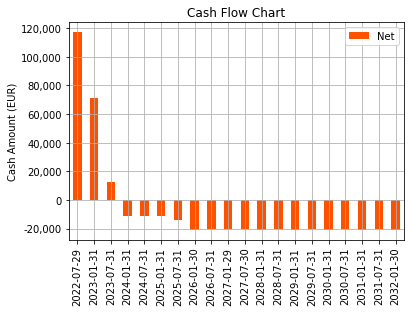

In [19]:
# Request portfolio cash flows
portfolio_cash_flows = transaction_portfolios_api.get_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=end_date,
    recipe_id_scope=market_data_scope,
    recipe_id_code=recipe_code
)

cash_flows = format_cash_flows_to_df(portfolio_cash_flows)

ax = cash_flows.plot.bar(y=['Net'], color = ['#ff5200'])
plt.title('Cash Flow Chart')
plt.ylabel('Cash Amount (EUR)')
display(cash_flows)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid()
plt.show()

### 2.3 Curves

Similarly, if we inspect the cash flows response, we will notice that we get back information relating back to the discount curve as well as the forward rates that will be used internally for a  valuation in the _'Discounting'_ model. These are plotted below for some visual aid on the curves used internally by the pricer.

,Forward Rate,Discount Factor,Year Fraction,Cumulative Year Fraction,Discount Rate
2022-07-29,-0.0050,1.0004,0.4694,0.4694,-0.0008
2023-01-31,0.0062,0.9971,0.5167,0.9861,0.0029
2023-07-31,0.0175,0.9884,0.5028,1.4889,0.0079
2024-01-31,0.0223,0.9772,0.5111,2.0000,0.0115
2024-07-31,0.0223,0.9664,0.5056,2.5056,0.0137
2025-01-31,0.0223,0.9555,0.5111,3.0167,0.0151
2025-07-31,0.0228,0.9447,0.5028,3.5194,0.0162
2026-01-30,0.0241,0.9333,0.5083,4.0278,0.0171
2026-07-31,0.0241,0.9220,0.5056,4.5333,0.0179
2027-01-29,0.0241,0.9110,0.5056,5.0389,0.0185


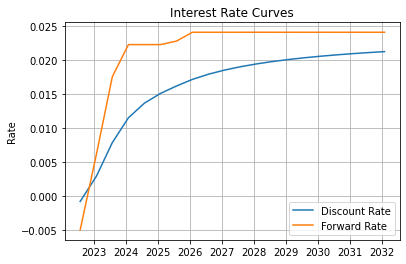

In [20]:
# Extract discount/forward curve information from cash flow response
curve_data = {
    element.payment_date.date(): {
        "Forward Rate": float(element.diagnostics.get("ForwardRate")),
        "Discount Factor": float(element.diagnostics.get("PaymentDateDiscountFactor")),
        "Year Fraction": float(element.diagnostics.get("DayCountFraction"))
    } for element in portfolio_cash_flows.values if element.diagnostics["PayReceive"] == "Pay"
}

# Create curve table
curve_df = pd.DataFrame.from_dict(curve_data, orient="index")
curve_df["Cumulative Year Fraction"] = curve_df["Year Fraction"].cumsum()
curve_df["Discount Rate"] = curve_df.apply(lambda x: -np.log(getattr(x, "Discount Factor"))/getattr(x, "Cumulative Year Fraction"), axis=1)
display(curve_df)

# Plot curves
curve_df.plot.line(y=["Discount Rate", "Forward Rate"])
plt.title('Interest Rate Curves')
plt.ylabel('Rate')
plt.grid()
plt.show()

### 2.4 Valuation

Below we prepare a request to the valuation engine in order to get results such as:
- NPV
- Accrued Interest
- Exposure/Notional

Notice that what is returned as part of the call depends on a set of `metrics` given in the request, which is an array of address keys for what is to be evaluated. A full list of address keys can be found under [_GetQueryableKeys_](https://www.lusid.com/docs/api#operation/GetQueryableKeys) endpoint.


In [21]:
# Method to query daily valuations
def get_daily_valuation(date, portfolio_scope, portfolio_code, recipe_scope, recipe_code, metrics, group_by=["Instrument/default/Name"]):

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=recipe_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=portfolio_scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    return vals_df


As we can see the NPV is negative, which is inline with the previously seen cash flow chart. Notice that the net flows are largely negative, which suggests the overall NPV of the payer leg to be higher to respect to the receiver leg.

In [22]:
# Set the queryable metrics and operation to be applied on the group_by level
metrics = [
    lm.AggregateSpec("Instrument/default/Name", "Value"),
    lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
    lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
    lm.AggregateSpec("Valuation/Accrued", "Value"),
    lm.AggregateSpec("Valuation/ExposureInPortfolioCcy", "Value"),
    lm.AggregateSpec("Holding/default/Units", "Value"),
        ]

df = get_daily_valuation(
    date=effective_at,
    portfolio_scope=portfolio_scope,
    portfolio_code=portfolio_code,
    recipe_scope=market_data_scope,
    recipe_code=recipe_code,
    metrics=metrics
)
df

,Instrument/default/Name,Instrument/default/ClientInternal,Valuation/PvInPortfolioCcy,Valuation/Accrued,Valuation/ExposureInPortfolioCcy,Holding/default/Units
0,EUROIS.REC.10Y,EUR-OIS-SWAP001,"-78,846.8596","86,047.8734","10,000,000.0000","10,000,000.0000"


### 2.5 Cash Flow Overrides

In addition to running validations through the internal pricer, LUSID is also capable of storing data coming in from external systems. All valuations relating to the swap can be ingested externally and stored giving users a rigid data model accessible via API.

In the example below we are going to override the cash flows of the swap based on some external figures. We will then see that we can adjust the recipe used in retrieving the cash flows to use these overrides.

Using the new recipe would allow a user to query portfolio cash flow projections for a book of derivatives using external projections rather than the LUSID ones seen before.

In [23]:
# Read external cash flow data
external_cash_flows = pd.read_csv("data/external_instrument_cash_flows.csv")
external_cash_flows["Dates"] = pd.to_datetime(external_cash_flows["Dates"])
df_add_utc(external_cash_flows)
external_cash_flows.head(10)

,Dates,Receive,Pay
0,2022-07-29 00:00:00+00:00,100000,"25,000.0000"
1,2023-01-31 00:00:00+00:00,100000,"25,000.0000"
2,2023-07-31 00:00:00+00:00,100000,"-100,100.0000"
3,2024-01-31 00:00:00+00:00,100000,"-100,200.1000"
4,2024-07-31 00:00:00+00:00,100000,"-100,300.3001"
5,2025-01-31 00:00:00+00:00,100000,"-100,400.6004"
6,2025-07-31 00:00:00+00:00,100000,"-100,501.0010"
7,2026-01-30 00:00:00+00:00,100000,"-100,601.5020"
8,2026-07-31 00:00:00+00:00,100000,"-100,702.1035"
9,2027-01-29 00:00:00+00:00,100000,"-100,802.8056"


Use the _StructuredResultDataApi_ to store the cash flows in LUSID. This will involve creating a _CashFlowValueSet_, as well as a structured result data ID which we will refer back to in the configuration recipe.

Notice that the cash flow overrides need to be unitized to the instrument's notional. We will therefore divide all document values by the instrument notional below prior to upserting.

In [24]:
document_scope = "CashOverride"
document_code ="EurOisIrs"

# Persist pay amounts
pay_leg_flows = [
    lm.CashFlowValue(
        result_value_type="CashFlowValue",
        payment_amount=row["Pay"]/notional * -1, # Unitize amount
        payment_date=row["Dates"],
        payment_ccy=instrument_ccy,
        cash_flow_lineage= lm.CashFlowLineage(
            cash_flow_type="Coupon",
            pay_receive="Pay"
        )
    ) for i, row in external_cash_flows.iterrows()
    ]


# Persist receive amounts
rec_leg_flows = [
    lm.CashFlowValue(
        result_value_type="CashFlowValue",
        payment_amount=row["Receive"]/notional, # Unitize amount
        payment_date=row["Dates"],
        payment_ccy=instrument_ccy,
        cash_flow_lineage= lm.CashFlowLineage(
            cash_flow_type="Coupon",
            pay_receive="Receive"
        )
    ) for i, row in external_cash_flows.iterrows()
    ]

# Create external cash flow set from pays and receives
external_cash_flow_set = lm.CashFlowValueSet(
    cashflows=pay_leg_flows + rec_leg_flows,
    result_value_type="CashFlowValueSet"
)

# Create a structured document ID
struct_result_data_id = lm.StructuredResultDataId(
    source = 'Client',
    code=document_code,
    effective_at= effective_at,
    result_type = "UnitResult/Analytic")

upsert_result_values_data_request = lm.UpsertResultValuesDataRequest(
    document_id=struct_result_data_id,
    key={
        f"UnitResult/LusidInstrumentId":f"{luid}" #Instrument to which document resolves
    },
    data_address="UnitResult/Valuation/Cashflows",  #Valuation result to override
    result_value=external_cash_flow_set
    )

response = structured_result_data_api.upsert_result_value(
    scope = document_scope,
    request_body={
        "CashFlows":upsert_result_values_data_request
    }
)

if len(response.failed) == 0:
    print(f"Cash Flow set has successfully been loaded into LUSID")
else:
    print("An error occurred with the above upsert_instruments call, see error message:", response.failed)

Cash Flow set has successfully been loaded into LUSID


In [25]:
# Create new recipe scope for overrides and result data 'ResultDataKeyRule'
custom_cash_recipe_scope = "CashOverride"
result_data_rules=[
            lm.ResultDataKeyRule(
                result_key_rule_type='ResultDataKeyRule',
                supplier= "Client",
                data_scope = document_scope,
                document_code = document_code,
                resource_key= "UnitResult/Valuation/Cashflows",
                document_result_type= "UnitResult/Analytic",
                quote_interval= "5D"
                )
            ]

# Add result_data_rules to configuration recipe and update scope
configuration_recipe.pricing.result_data_rules = result_data_rules
configuration_recipe.scope = custom_cash_recipe_scope

# Upsert object under new scope
response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)

print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2022-07-02 14:11:29.475014+00:00.


With the cash flows stored in LUSID against the instrument, we can now see that querying the portfolio cash flows come back with the external data.

In [26]:
# Request portfolio cash flows
external_portfolio_cash_flows = transaction_portfolios_api.get_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=end_date,
    recipe_id_scope=custom_cash_recipe_scope,
    recipe_id_code=recipe_code
)

cash_flows = format_cash_flows_to_df(external_portfolio_cash_flows)
display(cash_flows)

,Receive,Pay,Net
2022-07-29,"100,000.0000","25,000.0000","125,000.0000"
2023-01-31,"100,000.0000","25,000.0000","125,000.0000"
2023-07-31,"100,000.0000","-100,100.0000",-100.0000
2024-01-31,"100,000.0000","-100,200.1000",-200.1000
2024-07-31,"100,000.0000","-100,300.3001",-300.3001
2025-01-31,"100,000.0000","-100,400.6004",-400.6004
2025-07-31,"100,000.0000","-100,501.0010",-501.0010
2026-01-30,"100,000.0000","-100,601.5020",-601.5020
2026-07-31,"100,000.0000","-100,702.1035",-702.1035
2027-01-29,"100,000.0000","-100,802.8056",-802.8056


## 3. Instrument Life Cycle
### 3.1 Cash Handling on Payment Date

LUSID can handle instrument life cycle events in the form of transactions that alter the current position against the instrument. A user has the option to either ingest these events from an external system as part of their regular transaction and corporate action processing.

However, for many instrument's where the system has knowledge of upcoming events, it can be used directly to synthesize these. For example, the upcoming cash flows for an IRS are known in LUSID, so we can make an API call to _GetUpsertablePortfolioCashFlows_ which will return a transaction object ready to be upserted.

Below we will request the upsertable portfolio cash flows for the upcoming 100 days.

In [27]:
# Set the life cycle end date from our original effective date
life_cycle_end_date = effective_at + timedelta(days=100)

upsertable_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=effective_at,
    window_start=effective_at,
    window_end=life_cycle_end_date,
    recipe_id_scope=market_data_scope,
    recipe_id_code=recipe_code
)

lusid_response_to_data_frame(upsertable_cash_flows)

,transaction_id,type,instrument_identifiers,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties,source,entry_date_time,transaction_status
0,TXN001-LUID_00003DGA-20220729-Coupon-EUR-Receive,CashFlow,{},EurOisNotebook,LUID_00003DGA,2022-07-29 00:00:00+00:00,2022-07-29 00:00:00+00:00,"93,888.8889",1.0000,Price,"93,888.8889",EUR,1.0000,EUR,{},default,0001-01-01 00:00:00+00:00,Active
1,TXN001-LUID_00003DGA-20220729-Coupon-EUR-Pay,CashFlow,{},EurOisNotebook,LUID_00003DGA,2022-07-29 00:00:00+00:00,2022-07-29 00:00:00+00:00,"23,316.4492",1.0000,Price,"23,316.4492",EUR,1.0000,EUR,{},default,0001-01-01 00:00:00+00:00,Active


In [28]:
for element in upsertable_cash_flows.values:
    element.instrument_identifiers = {"Instrument/default/Currency": "EUR"}

# Upsert the transactions
response = transaction_portfolios_api.upsert_transactions(
    scope=portfolio_scope, code=portfolio_code, transaction_request=upsertable_cash_flows.values
)

print(f"Transaction updated for effective time: {response.version.effective_from}.")

Transaction updated for effective time: 2010-01-01 00:00:00+00:00.


We can now check the portfolio for its holdings post the payment event, where we notice that the net amount of cash for the payment period has settled.

In [32]:
# Check holdings post life cycle event
holdings = transaction_portfolios_api.get_holdings(
    scope=portfolio_scope,
    code=portfolio_code,
    effective_at=life_cycle_end_date
 )

lusid_response_to_data_frame(holdings)

,instrument_scope,instrument_uid,sub_holding_keys,properties.Holding/default/SourcePortfolioId.key,properties.Holding/default/SourcePortfolioId.value.label_value,properties.Holding/default/SourcePortfolioId.effective_from,properties.Holding/default/SourcePortfolioScope.key,properties.Holding/default/SourcePortfolioScope.value.label_value,properties.Holding/default/SourcePortfolioScope.effective_from,holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,cost_portfolio_ccy.currency,currency
0,EurOisNotebook,LUID_00003DGA,{},Holding/default/SourcePortfolioId,EUROIS-IRS-Example,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,P,"10,000,000.0000","10,000,000.0000","10,000,000.0000",EUR,"10,000,000.0000",EUR,EUR
1,default,CCY_EUR,{},Holding/default/SourcePortfolioId,EUROIS-IRS-Example,0001-01-01 00:00:00+00:00,Holding/default/SourcePortfolioScope,Finbourne-Examples,0001-01-01 00:00:00+00:00,B,"117,205.3389","117,205.3389","117,205.3400",EUR,"117,205.3400",EUR,EUR


## 4. P&L Reporting
### 4.1 A2B Report for P&L

Next we are going to run a LUSID A2B report on the portfolio, which will break down the P&L of the position for a given window.

In [31]:
# Helper function for displaying A2B Report
def format_a2b_df(response):
    a2b_df = lusid_response_to_data_frame(response, rename_properties=True)

    # Reduce column properties
    exclude = ["instrument_uid", "sub_holding_keys","currency","group_id", "portfolio_id.scope","portfolio_id.code", "holding_type", "instrument_scope", "end.portfolio_currency.components"]

    # Drop results in holding currency and results that indicate currency of the activity; we know that everything is in EUR in this example
    cols_to_drop = [col for col in a2b_df.columns for exclusion in exclude if (exclusion == col) or ("holding_currency" in col) or ("currency.currency" in col)]

    result = a2b_df.drop(columns=cols_to_drop)

    columns_to_rename = {
        "Name(default-Properties)": "Name",
        "start.portfolio_currency.components.Cost": "Start/Cost",
        "start.portfolio_currency.components.MarketGain": "Start/Market Gain",
        "start.portfolio_currency.total": "Start/Total",
        "gains.portfolio_currency.components.DeltaMarketGain": "Gains/Delta Market Gain",
        "gains.portfolio_currency.total": "Gains/Total",
        "end.portfolio_currency.components.Cost": "End/Cost",
        "end.portfolio_currency.components.MarketGain": "End/Market Gain",
        "end.portfolio_currency.total": "End/Total",
    }
    result=result[columns_to_rename.keys()]
    result.rename(columns=columns_to_rename, inplace=True)
    return result

# Request A2B report
a2b = transaction_portfolios_api.get_a2_b_data(
    scope=portfolio_scope,
    code=portfolio_code,
    from_effective_at=effective_at,
    to_effective_at=effective_at + timedelta(days=3),
    recipe_id_scope=market_data_scope,
    recipe_id_code=recipe_code,
    property_keys=["Instrument/default/Name"]
)

format_a2b_df(a2b)


,Name,Start/Cost,Start/Market Gain,Start/Total,Gains/Delta Market Gain,Gains/Total,End/Cost,End/Market Gain,End/Total
0,EUROIS.REC.10Y,"10,000,000.0000","-10,164,894.7300","-78,846.8600","-2,172.5200","-2,172.5200","10,000,000.0000","-10,167,067.2500","-78,870.3100"
